# PyTorch example to use CNN on MNIST dataset
[Example](https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/401_CNN.py) used from here, thanks.

 - View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
 - My Youtube Channel: https://www.youtube.com/user/MorvanZhou


In [1]:
# standard library
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [2]:
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate

In [3]:
# Some functions for plotting
plt.rcParams["figure.figsize"] = (15,10)

def plot_images(images):
    nr_images, height, width = images.shape
    images = np.squeeze(np.concatenate(np.split(images, nr_images, axis=0), axis=2))
    plt.imshow(images,  cmap='gray')
    
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)


torch.Size([60000, 28, 28])
torch.Size([60000])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


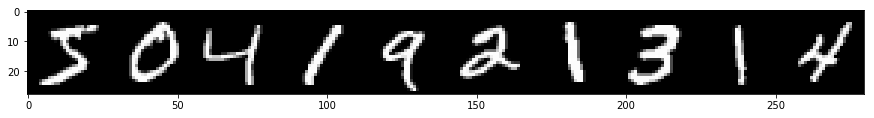

In [4]:
# Train data
DOWNLOAD_MNIST = not(os.path.exists('./data/mnist/'))

train_data = torchvision.datasets.MNIST(
    root='./data/mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# print shapes
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)

# plot examples
plot_images(train_data.train_data[:10, :, :].numpy())
print(train_data.train_labels[:10])


In [5]:
# Test data
# pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./data/mnist/', train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input channels
                out_channels=16,            # n_filters
                kernel_size=3,              # filter size
                stride=1,                   # filter movement/step
                padding=1,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 3, 1, 1),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [7]:
cnn = CNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [8]:
# Train the model
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader

        output, _ = cnn(b_x)            # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 200 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, "| step:", "%04d" % step, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

Epoch:  0 | step: 0000 | train loss: 2.3001 | test accuracy: 0.11
Epoch:  0 | step: 0200 | train loss: 0.1994 | test accuracy: 0.91
Epoch:  0 | step: 0400 | train loss: 0.2471 | test accuracy: 0.95
Epoch:  0 | step: 0600 | train loss: 0.0901 | test accuracy: 0.96
Epoch:  0 | step: 0800 | train loss: 0.0610 | test accuracy: 0.97
Epoch:  0 | step: 1000 | train loss: 0.1025 | test accuracy: 0.97


In [9]:
# Predict
test_output, last_layer = cnn(test_x)
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()

[4 7 5 3 4] prediction number
[4 7 5 3 4] real number


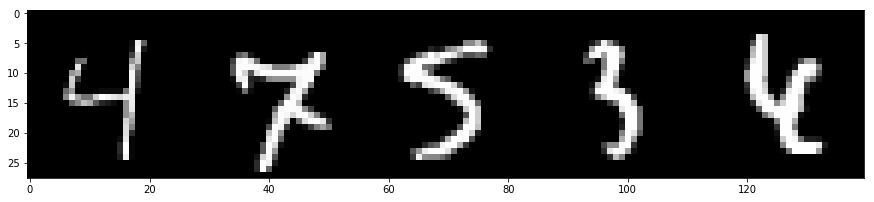

In [10]:
# Print random predictions
selection = np.random.choice(test_x.shape[0], 5)
print(pred_y[selection], 'prediction number')
print(test_y[selection].numpy(), 'real number')
plot_images(test_x[selection, 0, :, :].numpy())

[0 5 3 7 1] prediction number
[6 3 9 3 2] real number


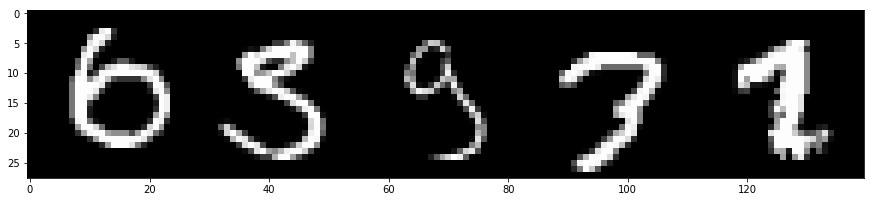

In [11]:
# Print wrong examples
wrong_examples = np.where(pred_y != test_y.numpy())[0]
selection = np.random.choice(wrong_examples, 5)
print(pred_y[selection], 'prediction number')
print(test_y[selection].numpy(), 'real number')
plot_images(test_x[selection, 0, :, :].numpy())

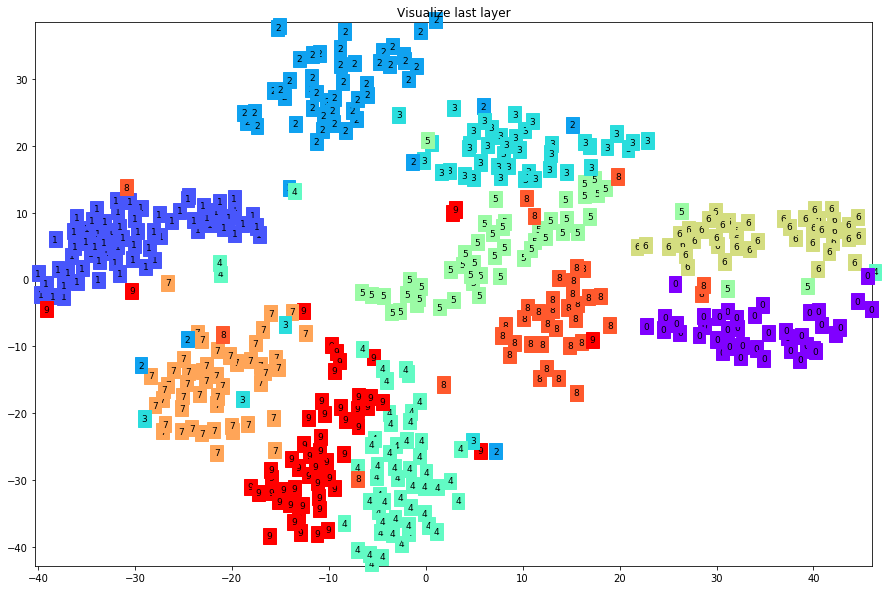

In [12]:
# Visualization of trained flatten layer (T-SNE)
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
labels = test_y.numpy()[:plot_only]
plot_with_labels(low_dim_embs, labels)